<a href="https://colab.research.google.com/github/AntoninaRemizova/ML/blob/main/ML_class_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт данных и библиотек

In [ ]:
!pip install pymorphy3 razdel matplotlib-venn
!pip install spacy
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 16.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
import requests
import os
import re
from collections import Counter
import spacy
import pymorphy3
from razdel import tokenize, sentenize
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nlp = spacy.load("ru_core_news_sm")
morph = pymorphy3.MorphAnalyzer()

In [ ]:
def download_text_from_github(author_name, filename):
    raw_url = f"https://raw.githubusercontent.com/d0rj/RusLit/main/poems/{author_name}/{filename}"
    try:
        response = requests.get(raw_url)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Ошибка загрузки {filename}: {response.status_code}")
            return None
    except Exception as e:
        print(f"Ошибка при загрузке {filename}: {e}")
        return None

def get_github_files(author_name):
    api_url = f"https://api.github.com/repos/d0rj/RusLit/contents/poems/{author_name}"
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            files_data = response.json()
            txt_files = [item['name'] for item in files_data if item['name'].endswith('.txt')]
            return txt_files
        else:
            print(f"Ошибка API: {response.status_code}")
            return []
    except Exception as e:
        print(f"Ошибка при получении списка файлов: {e}")
        return []

chekhov_files = get_github_files("Lermontov")
gogol_files = get_github_files("Nekrasov")

chekhov_texts = []
for file in chekhov_files[:50]:
    text = download_text_from_github("Lermontov", file)
    chekhov_texts.append(text)

gogol_texts = []
for file in gogol_files[:50]:
    text = download_text_from_github("Nekrasov", file)
    gogol_texts.append(text)

print(f"Лермонтов: {len(chekhov_texts)}")
print(f"Некрасов: {len(gogol_texts)}")

Лермонтов: 18
Некрасов: 15


# Частеречная разметка

In [ ]:
df_ch = pd.DataFrame(chekhov_texts)
df_go = pd.DataFrame(gogol_texts)

df_ch.columns = ['text']
df_go.columns = ['text']

df_ch['author'] = 0  # Лермонтов
df_go['author'] = 1  # Некрасов


data = pd.concat([df_ch, df_go], axis=0).reset_index(drop=True)

In [ ]:
data.head()

,text,author
0,А. О. СМИРНОВОЙ\nВ простосердечии невежды\nКор...,0
1,Михаил Лермонтов\nЭПИГРАММЫ\n1\nЕсть люди стра...,0
2,Михаил Лермонтов\nАНГЕЛ\nПо небу полуночи анге...,0
3,Михаил Лермонтов\nК НИНЕ\n(Из Шиллера)\nАх! со...,0
4,"Михаил Лермонтов\nБОРОДИНО\n— Скажи-ка, дядя, ...",0


In [ ]:
data['author'].value_counts()

,count
author,
0,18
1,15


In [ ]:
nlp = spacy.load("ru_core_news_sm")

In [ ]:
def apply_pos(text):
    doc = nlp(text)
    pos_tags = [token.pos_ for token in doc]
    return np.array(pos_tags)

In [ ]:
def extract_pos_features_safe(pos_list):
    features = {}

    pos_categories = [
        'ADJ', 'ADP', 'ADV', 'AUX', 'CCONJ', 'DET',
        'INTJ', 'NOUN', 'NUM', 'PART', 'PRON',
        'PUNCT', 'SCONJ', 'VERB', 'PROPN', 'SYM', 'X'
    ]

    for pos in pos_categories:
        indices = np.where(pos_list == pos)[0]
        count = len(indices)


        features[f'{pos}_col'] = count

        if count > 0:
            avg_pos = np.sum(indices) / count
            features[pos] = avg_pos
        else:
            features[pos] = 0

    return features

In [ ]:
df = pd.DataFrame()

In [ ]:
for i in range(data.shape[0]):
    PoS_list = apply_pos(data.iloc[i]['text'])
    df = pd.concat([df, pd.DataFrame({
    'ADJ': [np.sum(np.where(PoS_list == 'ADJ')[0])/np.where(PoS_list == 'ADJ')[0].shape[0]],
    'ADJ_col': [np.where(PoS_list == 'ADJ')[0].shape[0]],
    'ADP': [np.sum(np.where(PoS_list == 'ADP')[0])/np.where(PoS_list == 'ADP')[0].shape[0]],
    'ADP_col': [np.where(PoS_list == 'ADP')[0].shape[0]],
    'ADV': [np.sum(np.where(PoS_list == 'ADV')[0])/np.where(PoS_list == 'ADV')[0].shape[0]],
    'ADV_col': [np.where(PoS_list == 'ADV')[0].shape[0]],
    'AUX': [np.sum(np.where(PoS_list == 'AUX')[0])/np.where(PoS_list == 'AUX')[0].shape[0]],
    'AUX_col': [np.where(PoS_list == 'AUX')[0].shape[0]],
    'CCONJ': [np.sum(np.where(PoS_list == 'CCONJ')[0])/np.where(PoS_list == 'CCONJ')[0].shape[0]],
    'CCONJ_col': [np.where(PoS_list == 'CCONJ')[0].shape[0]],
    'DET': [np.sum(np.where(PoS_list == 'DET')[0])/np.where(PoS_list == 'DET')[0].shape[0]],
    'DET_col': [np.where(PoS_list == 'DET')[0].shape[0]],
    'INTJ': [np.sum(np.where(PoS_list == 'INTJ')[0])/np.where(PoS_list == 'INTJ')[0].shape[0]],
    'INTJ_col': [np.where(PoS_list == 'INTJ')[0].shape[0]],
    'NOUN': [np.sum(np.where(PoS_list == 'NOUN')[0])/np.where(PoS_list == 'NOUN')[0].shape[0]],
    'NOUN_col': [np.where(PoS_list == 'NOUN')[0].shape[0]],
    'NUM': [np.sum(np.where(PoS_list == 'NUM')[0])/np.where(PoS_list == 'NUM')[0].shape[0]],
    'NUM_col': [np.where(PoS_list == 'NUM')[0].shape[0]],
    'PART': [np.sum(np.where(PoS_list == 'PART')[0])/np.where(PoS_list == 'PART')[0].shape[0]],
    'PART_col': [np.where(PoS_list == 'PART')[0].shape[0]],
    'PRON': [np.sum(np.where(PoS_list == 'PRON')[0])/np.where(PoS_list == 'PRON')[0].shape[0]],
    'PRON_col': [np.where(PoS_list == 'PRON')[0].shape[0]],
    'PUNCT': [np.sum(np.where(PoS_list == 'PUNCT')[0])/np.where(PoS_list == 'PUNCT')[0].shape[0]],
    'PUNCT_col': [np.where(PoS_list == 'PUNCT')[0].shape[0]],
    'SCONJ': [np.sum(np.where(PoS_list == 'SCONJ')[0])/np.where(PoS_list == 'SCONJ')[0].shape[0]],
    'SCONJ_col': [np.where(PoS_list == 'SCONJ')[0].shape[0]],
    'VERB': [np.sum(np.where(PoS_list == 'VERB')[0])/np.where(PoS_list == 'VERB')[0].shape[0]],
    'VERB_col': [np.where(PoS_list == 'VERB')[0].shape[0]],
    })], axis=0)

In [ ]:
df = df.reset_index()
df = df.drop(columns='index')
df.head()

,ADJ,ADJ_col,ADP,ADP_col,ADV,ADV_col,AUX,AUX_col,CCONJ,CCONJ_col,...,PART,PART_col,PRON,PRON_col,PUNCT,PUNCT_col,SCONJ,SCONJ_col,VERB,VERB_col
0,61.750000,4,29.000000,4,38.222222,9,80.750000,4,35.666667,3,...,71.666667,3,39.153846,13,49.133333,15,NaN,0,38.727273,11
1,53.200000,5,104.076923,13,105.714286,7,65.000000,1,90.625000,8,...,112.250000,8,113.545455,11,112.589744,39,122.000000,5,112.458333,24
2,62.555556,9,57.555556,9,92.000000,1,58.000000,1,55.600000,10,...,108.000000,1,61.000000,6,61.923077,13,NaN,0,60.384615,13
3,56.888889,9,27.500000,6,85.000000,2,69.000000,1,63.000000,3,...,69.250000,4,65.000000,4,63.043478,23,78.333333,3,70.500000,8
4,334.242424,33,327.461538,39,268.611111,18,274.555556,9,371.666667,15,...,302.551724,29,325.823529,34,317.650407,123,302.800000,10,346.012987,77


In [ ]:
df = df.fillna(0)

In [ ]:
df['Class'] = data['author']

df = df.sample(frac=1).reset_index(drop=True)
df

,ADJ,ADJ_col,ADP,ADP_col,ADV,ADV_col,AUX,AUX_col,CCONJ,CCONJ_col,...,PART_col,PRON,PRON_col,PUNCT,PUNCT_col,SCONJ,SCONJ_col,VERB,VERB_col,Class
0,557.325843,89,533.985294,68,628.676471,34,620.500000,4,614.857143,28,...,30,575.578947,57,624.454887,266,358.666667,9,628.533835,133,1
1,258.382353,34,261.296296,27,214.111111,9,90.600000,5,262.388889,18,...,16,228.074074,27,236.325843,89,61.666667,6,202.178571,56,1
2,55.750000,8,43.714286,7,40.333333,3,0.000000,0,50.000000,1,...,6,35.400000,5,40.062500,16,0.000000,0,45.571429,7,1
3,76.000000,13,62.250000,4,48.500000,10,0.000000,0,64.375000,8,...,2,41.500000,10,50.789474,19,0.000000,0,37.200000,10,1
4,53.200000,5,104.076923,13,105.714286,7,65.000000,1,90.625000,8,...,8,113.545455,11,112.589744,39,122.000000,5,112.458333,24,0
5,34.875000,8,24.400000,5,45.000000,3,0.000000,0,52.000000,4,...,0,30.000000,2,44.818182,11,46.000000,1,33.571429,7,0
6,3529.423913,460,3558.162839,479,3588.543779,217,3469.909091,44,3433.286996,223,...,198,3464.826211,351,3670.047900,1357,2818.823529,68,3586.073009,904,1
7,61.750000,4,29.000000,4,38.222222,9,80.750000,4,35.666667,3,...,3,39.153846,13,49.133333,15,0.000000,0,38.727273,11,0
8,876.370000,100,888.259615,104,903.254717,106,1136.200000,10,942.644737,76,...,49,813.055046,109,915.163889,360,768.944444,18,924.927835,194,0
9,173.931034,29,166.884615,26,206.666667,9,0.000000,0,210.600000,25,...,8,156.052632,19,170.363636,55,130.333333,3,207.111111,27,0


# Обучение моделей

In [ ]:
X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'SVM': SVC(probability=True, random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced')
}

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}
predictions = {}
predicted_probas = {}

In [ ]:
for name, model in models.items():
    if name in ['SVM', 'Logistic Regression']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test

    model.fit(X_tr, y_train)
    y_pred = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    predictions[name] = y_pred
    predicted_probas[name] = y_proba

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }

    print(f"\n{name}:")
    print(f"Accuracy: {results[name]['Accuracy']:.2f}")
    print(f"Precision: {results[name]['Precision']:.2f}")
    print(f"Recall: {results[name]['Recall']:.2f}")
    print(f"F1-score: {results[name]['F1']:.2f}")


Random Forest:
Accuracy: 0.57
Precision: 0.50
Recall: 0.33
F1-score: 0.40

SVM:
Accuracy: 0.57
Precision: 0.00
Recall: 0.00
F1-score: 0.00

Logistic Regression:
Accuracy: 0.71
Precision: 1.00
Recall: 0.33
F1-score: 0.50


# Сравнение моделей

In [ ]:
metrics_df = pd.DataFrame(results).T
metrics_df

,Accuracy,Precision,Recall,F1
Random Forest,0.571429,0.5,0.333333,0.4
SVM,0.571429,0.0,0.000000,0.0
Logistic Regression,0.714286,1.0,0.333333,0.5


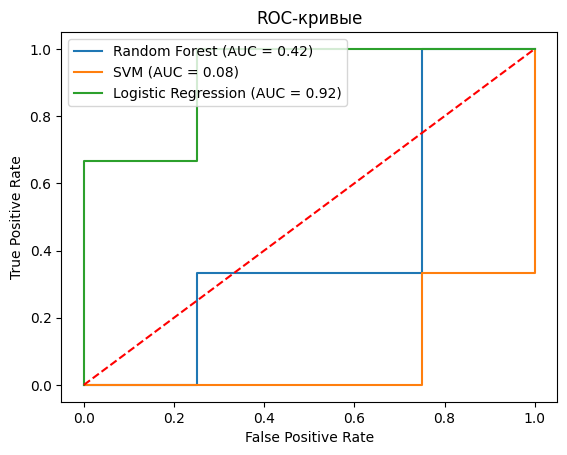

In [ ]:
for name in models.keys():
    fpr, tpr, _ = roc_curve(y_test, predicted_probas[name])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend()

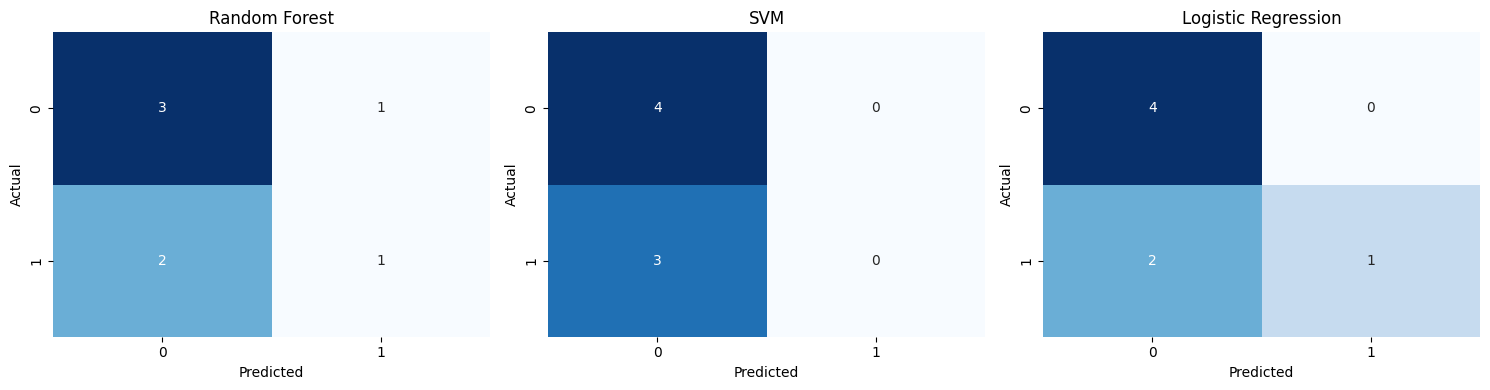

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

# Синтаксические характеристики

In [ ]:
def extract_syntactic_features(text):
    sentences = list(sentenize(text))
    doc = nlp(text)

    features = {}

    if sentences:
        avg_sentence_length = np.mean([len(list(tokenize(sent.text))) for sent in sentences])
        features['avg_sentence_length'] = avg_sentence_length

        punctuation_marks = [token for token in doc if token.is_punct]
        features['punctuation_count'] = len(punctuation_marks)
        features['punctuation_ratio'] = len(punctuation_marks) / len([token for token in doc if not token.is_space]) if doc else 0

        punct_types = Counter([token.text for token in punctuation_marks])
        features['punctuation_variety'] = len(punct_types)

        if punctuation_marks:
            punct_positions = [i/len(doc) for i, token in enumerate(doc) if token.is_punct]
            features['avg_punct_position'] = np.mean(punct_positions)
        else:
            features['avg_punct_position'] = 0

    return features

In [ ]:
syntactic_features = []
all_texts = chekhov_texts + gogol_texts

for text in all_texts:
    syn_features = extract_syntactic_features(text)
    syntactic_features.append(syn_features)

df_syntactic = df.copy()
for i, feature_dict in enumerate(syntactic_features):
    for key, value in feature_dict.items():
        df_syntactic.loc[i, key] = value

df_syntactic = df_syntactic.fillna(0)

In [ ]:
X_syn = df_syntactic.drop(['Class'], axis=1)
y_syn = df_syntactic['Class']

X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.2, random_state=42, stratify=y_syn)

results_syn = {}

In [ ]:
for name, model in models.items():
    if name in ['SVM', 'Logistic Regression']:
        scaler_syn = StandardScaler()
        X_train_syn_scaled = scaler_syn.fit_transform(X_train_syn)
        X_test_syn_scaled = scaler_syn.transform(X_test_syn)
        X_tr = X_train_syn_scaled
        X_te = X_test_syn_scaled
    else:
        X_tr = X_train_syn
        X_te = X_test_syn

    model.fit(X_tr, y_train_syn)
    y_pred_syn = model.predict(X_te)

    results_syn[name] = {
        'Accuracy': accuracy_score(y_test_syn, y_pred_syn),
        'Precision': precision_score(y_test_syn, y_pred_syn),
        'Recall': recall_score(y_test_syn, y_pred_syn),
        'F1': f1_score(y_test_syn, y_pred_syn)
    }

In [ ]:
comparison = pd.DataFrame({
    'Accuracy': [results[name]['Accuracy'] for name in models.keys()],
    'Accuracy (+синт)': [results_syn[name]['Accuracy'] for name in models.keys()],
    'Precision': [results[name]['Precision'] for name in models.keys()],
    'Precision (+синт)': [results_syn[name]['Precision'] for name in models.keys()],
    'Recall': [results[name]['Recall'] for name in models.keys()],
    'Recall (+синт)': [results_syn[name]['Recall'] for name in models.keys()],
    'F1': [results[name]['F1'] for name in models.keys()],
    'F1 (+синт)': [results_syn[name]['F1'] for name in models.keys()]
}, index=models.keys())

comparison

,Accuracy,Accuracy (+синт),Precision,Precision (+синт),Recall,Recall (+синт),F1,F1 (+синт)
Random Forest,0.571429,0.571429,0.5,0.500000,0.333333,0.666667,0.4,0.571429
SVM,0.571429,0.428571,0.0,0.000000,0.000000,0.000000,0.0,0.000000
Logistic Regression,0.714286,0.714286,1.0,0.666667,0.333333,0.666667,0.5,0.666667


# Лексико-стилистические показатели

In [ ]:
def calculate_lexical_metrics(text):
    tokens = [token.text.lower() for token in nlp(text) if token.is_alpha]
    words = [token for token in tokens if token.isalpha()]

    if not words:
        return {}

    # Индекс дистрибуции
    vocab_size = len(set(words))
    total_words = len(words)
    distribution_index = vocab_size / total_words if total_words > 0 else 0

    # Индекс итерации
    word_freq = Counter(words)
    iteration_index = sum([freq for freq in word_freq.values() if freq > 1]) / total_words if total_words > 0 else 0

    # Индекс исключительности
    rare_words = sum(1 for word, freq in word_freq.items() if freq == 1)
    exclusivity_index = rare_words / vocab_size if vocab_size > 0 else 0

    # Индекс плотности текста
    sentences = list(sentenize(text))
    avg_words_per_sentence = total_words / len(sentences) if sentences else 0
    density_index = total_words / (len(sentences) * avg_words_per_sentence) if avg_words_per_sentence > 0 else 0

    return {
        'distribution_index': distribution_index,
        'iteration_index': iteration_index,
        'exclusivity_index': exclusivity_index,
        'density_index': density_index,
        'vocab_size': vocab_size,
        'total_words': total_words
    }

In [ ]:
lexical_features = []
for text in all_texts:
    lex_features = calculate_lexical_metrics(text)
    lexical_features.append(lex_features)


df_lexical = df_syntactic.copy()
for i, feature_dict in enumerate(lexical_features):
    for key, value in feature_dict.items():
        df_lexical.loc[i, key] = value

df_lexical = df_lexical.fillna(0)

In [ ]:
X_lex = df_lexical.drop(['Class'], axis=1)
y_lex = df_lexical['Class']

X_train_lex, X_test_lex, y_train_lex, y_test_lex = train_test_split(
    X_lex, y_lex, test_size=0.2, random_state=42, stratify=y_lex)

results_lex = {}

In [ ]:
models_lex = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42)
}

In [ ]:
for name, model in models.items():
    if name in ['SVM', 'Logistic Regression']:
        scaler_lex = StandardScaler()
        X_train_lex_scaled = scaler_lex.fit_transform(X_train_lex)
        X_test_lex_scaled = scaler_lex.transform(X_test_lex)
        X_tr = X_train_lex_scaled
        X_te = X_test_lex_scaled
    else:
        X_tr = X_train_lex
        X_te = X_test_lex

    model.fit(X_tr, y_train_lex)
    y_pred_lex = model.predict(X_te)

    results_lex[name] = {
        'Accuracy': accuracy_score(y_test_lex, y_pred_lex),
        'Precision': precision_score(y_test_lex, y_pred_lex),
        'Recall': recall_score(y_test_lex, y_pred_lex),
        'F1': f1_score(y_test_lex, y_pred_lex)
    }

In [ ]:
comparison_compact = pd.DataFrame({
    'Accuracy': [results[name]['Accuracy'] for name in models.keys()],
    'Accuracy (синт)': [results_syn[name]['Accuracy'] for name in models.keys()],
    'Accuracy (лексика)': [results_lex[name]['Accuracy'] for name in models.keys()],
    'Precision': [results[name]['Precision'] for name in models.keys()],
    'Precision (синт)': [results_syn[name]['Precision'] for name in models.keys()],
    'Precision (лексика)': [results_lex[name]['Precision'] for name in models.keys()],
    'Recall': [results[name]['Recall'] for name in models.keys()],
    'Recall (синт)': [results_syn[name]['Recall'] for name in models.keys()],
    'Recall (лексика)': [results_lex[name]['Recall'] for name in models.keys()],
    'F1': [results[name]['F1'] for name in models.keys()],
    'F1 (синт)': [results_syn[name]['F1'] for name in models.keys()],
    'F1 (лексика)': [results_lex[name]['F1'] for name in models.keys()]
}, index=models.keys())

comparison_compact.round(3)

,Accuracy,Accuracy (синт),Accuracy (лексика),Precision,Precision (синт),Precision (лексика),Recall,Recall (синт),Recall (лексика),F1,F1 (синт),F1 (лексика)
Random Forest,0.571,0.571,0.571,0.5,0.500,0.500,0.333,0.667,0.667,0.4,0.571,0.571
SVM,0.571,0.429,0.429,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000
Logistic Regression,0.714,0.714,0.714,1.0,0.667,0.667,0.333,0.667,0.667,0.5,0.667,0.667
